In [26]:
from random import random, seed
from itertools import product, combinations, accumulate
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic


Reproducible Initialization

If you want to get reproducible results, use rng (and restart the kernel); for non-reproducible ones, use np.random.


In [27]:
UNIVERSE_SIZE = 10000
NUM_SETS = 1000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [28]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

Helper Functions

In [33]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    if not solution.any():
        return np.float64('inf')
    return COSTS[solution].sum()

def covered_elements(solution):
    """Returns the number of elements covered by the cover-set"""
    return np.logical_or.reduce(SETS[solution]).sum()

def fitness (solution: np.ndarray):
    return (valid(solution), cost(solution))

Have Fun!

In [14]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(34351.01065326614))

In [51]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.False_, np.float64(139.45599412083828))

# Solution given by a greedy algorithm
the goal is to iteratively select the set that provides the best "cost-effectiveness", i.e. the set that covers the most uncovered elements for the least cost, until all elements in the universe are covered.

In [32]:
# SETS is the binary matrix (NUM_SETS, UNIVERSE_SIZE)
# COSTS is the cost array for each set

def greedy_set_cover(SETS, COSTS):
    UNIVERSE_SIZE = SETS.shape[1]
    NUM_SETS = SETS.shape[0]
    
    # Step 1: Initialize
    covered_elements = np.zeros(UNIVERSE_SIZE, dtype=bool)  # Track covered elements
    selected_sets = []  # Store selected set indices

    # Keep track of how many elements are still uncovered
    uncovered_count = np.sum(~covered_elements)
    
    # Step 2: Iteratively select sets
    while uncovered_count > 0:
        best_set = None
        best_value = -1

        # Find the set with the best cost-effectiveness
        for i in range(NUM_SETS):
            if i in selected_sets:
                continue  # Skip already selected sets
            
            # Get the elements covered by this set but not already covered
            uncovered_by_set = SETS[i] & ~covered_elements
            newly_covered = np.sum(uncovered_by_set)
            
            # Calculate cost-effectiveness: new elements covered per unit cost
            if newly_covered > 0:
                value = newly_covered / COSTS[i]
                if value > best_value:
                    best_value = value
                    best_set = i

        # Step 3: Select the best set
        if best_set is None:
            break  # No further progress can be made, but this shouldn't happen

        selected_sets.append(best_set)
        covered_elements |= SETS[best_set]  # Mark newly covered elements
        
        # Update uncovered count
        uncovered_count = np.sum(~covered_elements)
    
    return selected_sets, covered_elements

# Run the greedy algorithm
selected_sets, covered_elements = greedy_set_cover(SETS, COSTS)

# Output results
print(f"Number of sets selected: {len(selected_sets)}")
print(f"Are all elements covered? {'Yes' if np.all(covered_elements) else 'No'}")
print(f"Selected sets: {selected_sets}")

solution_cost = 0
for index in selected_sets:
    solution_cost+=COSTS[index]

print(f"Cost of the solution: {solution_cost}")


Number of sets selected: 24
Are all elements covered? Yes
Selected sets: [294, 863, 729, 33, 171, 596, 467, 831, 317, 725, 393, 779, 999, 491, 616, 528, 417, 356, 795, 739, 426, 446, 670, 631]
Cost of the solution: 101403.52468155968


# Solving using a brute force algorithm

In [14]:
# SETS is the binary matrix (NUM_SETS, UNIVERSE_SIZE)
# COSTS is the cost array for each set

def combinatorial_set_cover(SETS, COSTS):
    UNIVERSE_SIZE = SETS.shape[1]
    NUM_SETS = SETS.shape[0]
    
    best_combination = None
    min_cost = float('inf')

    # Iterate over all possible set sizes from 1 to NUM_SETS
    for r in range(1, NUM_SETS + 1):
        # Generate all combinations of r sets
        for combo in combinations(range(NUM_SETS), r):
            # Step 1: Check if this combination covers the universe
            covered_elements = np.zeros(UNIVERSE_SIZE, dtype=bool)
            
            # Union of all sets in the combination
            for i in combo:
                covered_elements |= SETS[i]
            
            # Step 2: If it covers all elements, calculate the cost
            if np.all(covered_elements):  # Universe fully covered
                total_cost = sum(COSTS[i] for i in combo)
                
                # Step 3: Keep track of the minimum cost combination
                if total_cost < min_cost:
                    min_cost = total_cost
                    best_combination = combo
    
    return best_combination, min_cost

# Run the combinatorial algorithm
best_combination, min_cost = combinatorial_set_cover(SETS, COSTS)

# Output results
if best_combination is not None:
    print(f"Best combination of sets: {best_combination}")
    print(f"Minimum cost: {min_cost}")
else:
    print("No valid set cover found")


Best combination of sets: (0, 1, 2, 3, 5, 6, 7, 8, 9)
Minimum cost: 254.9091703989164


# Solving using a hill-climbing approach

## Approach 1: adding solutions till the reach of the target

ic| fitness(solution): (np.False_, np.float64(inf))
ic| fitness(solution): (np.True_, np.float64(157690.5518826986))


np.float64(157690.5518826986)

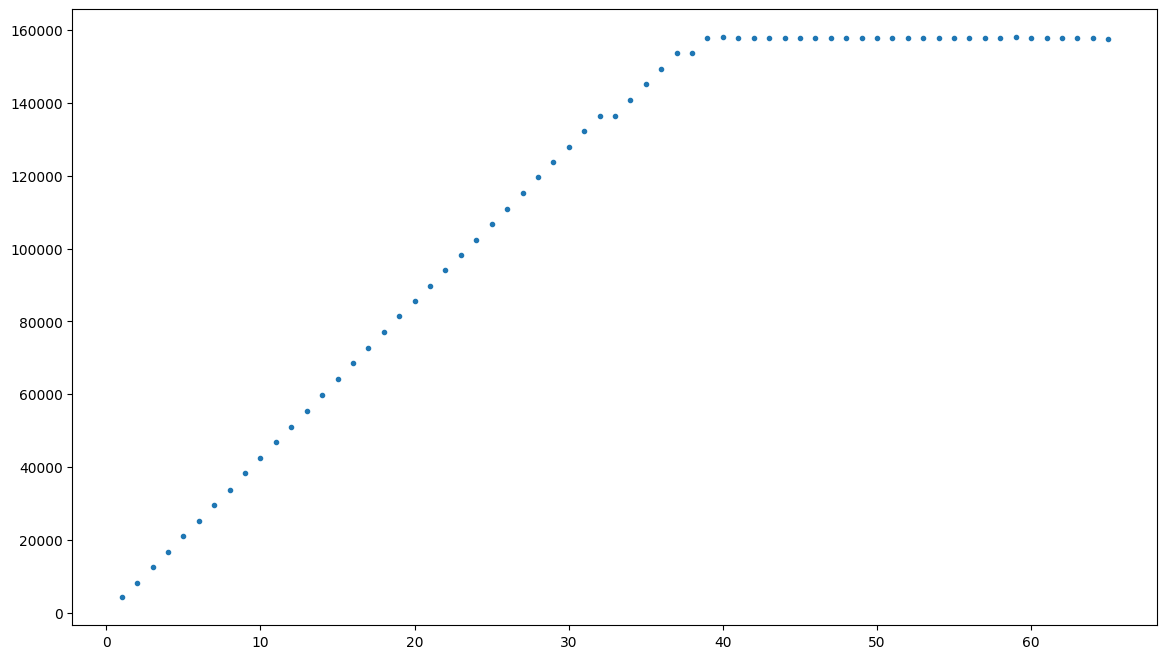

In [34]:
# SETS is the binary matrix (NUM_SETS, UNIVERSE_SIZE)
# COSTS is the cost array for each set

solution=np.full(NUM_SETS, False)
solution_fitness = fitness(solution)
history = [float(solution_fitness[1])]
ic(fitness(solution))

while not valid(solution):

    #choosing a random set to add to our solution

    old_coverage=covered_elements(solution)

    rand_index=None

    while rand_index is None or solution[rand_index]:
        rand_index=np.random.randint(0,NUM_SETS)

    solution[rand_index]=True
    
    f = fitness (solution)
    history.append(float(f[1]))

    #we want our solution to expand the total coverage
    # Get the elements covered by this set but not already covered
    newly_coverage = covered_elements(solution)

    if not newly_coverage>old_coverage:
        solution[rand_index]=False
        
ic(fitness(solution))
plt.figure(figsize= (14, 8))
plt.plot (
    range(len(history)),
    list(accumulate(history, max)),
    color ="red",
)

_ = plt.scatter(range(len(history)), history, marker = ".")


cost(solution)
    

## Approach 2
Starting with the obvious solution to consider all the sets, exclude one random set at the time which does not invalidate the correctness of the cover set; this is done until we reach a target threshold of considered sets given

In [35]:
threshold = 0.01
time_limit = 100_000

ic| fitness(solution

): (np.True_, np.float64(4275986.920593545))
ic| fitness(solution): (np.True_, np.float64(856697.8865352259))


856697.8865352259


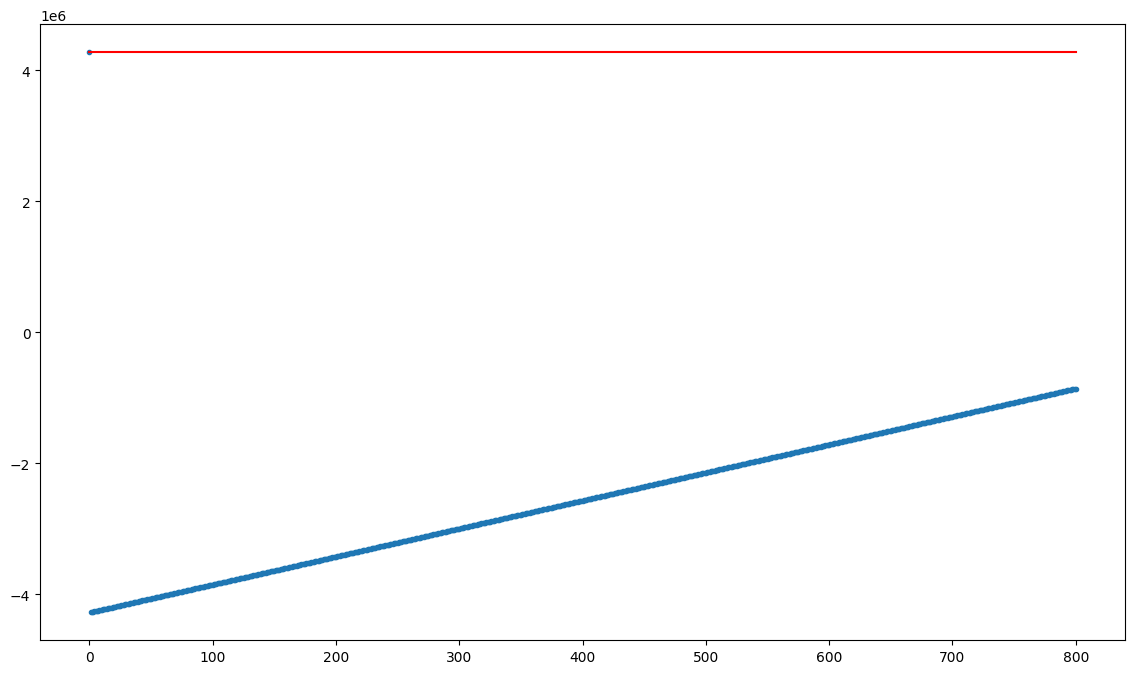

In [37]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
#sets a 'time' (iterations) limit in case the threshold is not approachable in reasonable time
did_not_commit_changes=0
#keeps track of items which invalidate the solution, helps reduce computation time
unchangable_items=[]

solution_fitness = fitness(solution)
history = [float(solution_fitness[1])]
ic(fitness(solution))

while SETS[solution].shape[0]/NUM_SETS>threshold and did_not_commit_changes<time_limit:
    rand_index=None

    while rand_index is None or not solution[rand_index] or rand_index in unchangable_items:
        rand_index=np.random.randint(0,NUM_SETS)
    
    solution[rand_index]=False

    if not valid(solution):
        did_not_commit_changes+=1
        solution[rand_index]=True
        unchangable_items.append(rand_index)
        if len(unchangable_items)/NUM_SETS > 0.5:
            break

    else:
        did_not_commit_changes=0
        f = fitness (solution)
        history.append(float(f[1]))


print(cost(solution))

if did_not_commit_changes==time_limit:
    print("Time limit exceeded")

ic(fitness(solution))
plt.figure(figsize= (14, 8))
plt.plot (
    range(len(history)),
    list(accumulate(history, max)),
    color ="red",
)

_ = plt.scatter(range(len(history)), history, marker = ".")


## Approach 3
built from bottom-up considering xosts, implementing tweaks and concept of 'simulated aneling'

In [45]:
candidates_nr=3
tweak_tolerance = 1.25

def tweak(sol,tweak):
    # Perform logical NOT on the specified indices
    sol[tweak] = np.logical_not(sol[tweak])
    return sol

In [46]:
# SETS is the binary matrix (NUM_SETS, UNIVERSE_SIZE)
# COSTS is the cost array for each set

solution=np.full(NUM_SETS, False)

solution_fitness = fitness(solution)
history = [float(solution_fitness[1])]
ic(fitness(solution))

while not valid(solution):

    #choosing a random set to add to our solution

    old_coverage=covered_elements(solution)

    rand_index=None
    candidates=[]

    while len(candidates)<candidates_nr:

        rand_index=np.random.randint(0,NUM_SETS)

        if(rand_index not in candidates):
            candidates.append(rand_index)


    
    new_sol = tweak(solution.copy(),np.array(candidates))

    old_Cost= cost(solution)
    new_cost = cost(new_sol)

    if cost(new_sol)>cost(solution):
        if covered_elements(new_sol) > covered_elements(solution) or new_cost/old_Cost > tweak_tolerance:
            solution=new_sol

    else:
        solution=new_sol

    f = fitness (new_sol)
    history.append(float(f[1]))


    
cost(solution)

ic(fitness(solution))
plt.figure(figsize= (14, 8))
plt.plot (
    range(len(history)),
    list(accumulate(history, max)),
    color ="red",
)

_ = plt.scatter(range(len(history)), history, marker = ".")


np.float64(2415922.122431904)